# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LCEL RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [10]:
!pip install -qU langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere lxml 
#-qU
#removed -qU and added protobuf==3.20.3
#first check on terminal: xcode-select --install
#check on terminal pip install --upgrade pip setuptools wheel



In [11]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

This is necessary for Colab.

In [12]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using Qdrant, Hugging Face, and LCEL

Now that we have a grasp on how LCEL works, and how we can use LangChain and Hugging Face to interact with our data - let's step it up a notch and incorporate Qdrant!

## LangChain Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

We'll use a SiteMapLoader to scrape the LangChain blogs - which will serve as our data for today!

### Data Collection

We'll be leveraging the `SitemapLoader` to load our PDF directly from the web!

In [13]:
from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load()

USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 220/220 [01:44<00:00,  2.11it/s]


### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [54]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(documents)

In [55]:
len(split_chunks)

4821

Alright, now we have 516 ~200 token long documents.

Let's verify the process worked as intended by checking our max document length.

In [16]:
max_chunk_length = 0

for chunk in split_chunks:
  max_chunk_length = max(max_chunk_length, len(chunk.page_content))

print(max_chunk_length)

499


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [17]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=split_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [18]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the LCEL we touched on earlier to create a RAG chain.

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

####🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [56]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
You are a helpful assistant. 
Think step by step before leveraging the information from the context to generate an answer.
If the context is unrelated to the answer or vice versa, do not answer.

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

We'll set our Generator - `gpt-4o` in this case - below!

In [57]:
from langchain_openai.chat_models import ChatOpenAI

base_llm = ChatOpenAI(model="gpt-4o-mini", tags=["base_llm"])

#### Our RAG Chain

Notice how we have a bit of a more complex chain this time - that's because we want to return our sources with the response.

Let's break down the chain step-by-step:

1. We invoke the chain with the `question` item. Notice how we only need to provide `question` since both the retreiver and the `"question"` object depend on it.
  - We also chain our `"question"` into our `retriever`! This is what ultimately collects the context through Qdrant.
2. We assign our collected context to a `RunnablePassthrough()` from the previous object. This is going to let us simply pass it through to the next step, but still allow us to run that section of the chain.
3. We finally collect our response by chaining our prompt, which expects both a `"question"` and `"context"`, into our `llm`. We also, collect the `"context"` again so we can output it in the final response object.

The key thing to keep in mind here is that we need to pass our context through *after* we've retrieved it - to populate the object in a way that doesn't require us to call it or try and use it for something else.

In [58]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm, "context": itemgetter("context")}
)

Let's get a visual understanding of our chain!

In [59]:
!pip install -qU grandalf

In [60]:
print(retrieval_augmented_qa_chain.get_graph().draw_ascii())

          +---------------------------------+      
          | Parallel<context,question>Input |      
          +---------------------------------+      
                    **            **               
                  **                **             
                **                    **           
         +--------+                     **         
         | Lambda |                      *         
         +--------+                      *         
              *                          *         
              *                          *         
              *                          *         
  +----------------------+          +--------+     
  | VectorStoreRetriever |          | Lambda |     
  +----------------------+          +--------+     
                    **            **               
                      **        **                 
                        **    **                   
          +----------------------------------+     
          | 

Let's try another visual representation:

![image](https://i.imgur.com/Ad31AhL.png)

Let's test our chain out!

In [61]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What's new in LangChain v0.2?"})

In [63]:
response["response"].content

'LangChain v0.2 includes several notable updates and improvements:\n\n1. **Full Separation of LangChain and LangChain-Community**: This separation allows for a more organized structure where langchain-community now depends on langchain-core and langchain.\n\n2. **Versioned Documentation**: The release introduces new and versioned documentation to enhance usability and accessibility.\n\n3. **Mature and Controllable Agent Framework**: There are improvements in the agent framework, making it more robust and manageable.\n\n4. **Improved LLM Interface Standardization**: Enhancements have been made particularly around tool calling, which improves the integration and functionality of the language model interfaces.\n\n5. **Streaming Support**: The release adds support for streaming, enhancing the capabilities of the framework.\n\n6. **30+ New Partner Packages**: There are numerous new partner packages that expand the ecosystem.\n\nThis pre-release aims to enhance the stability and security of 

In [64]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content='Four months ago, we released the first stable version of LangChain. Today, we are following up by announcing a pre-release of langchain v0.2.This release builds upon the foundation laid in v0.1 and incorporates community feedback. We’re excited to share that v0.2 brings: A much-desired full separation of langchain and langchain-community New (and versioned!) docs A more mature and controllable agent framework Improved LLM interface standardization, particularly around tool callingBetter' metadata={'source': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'loc': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'lastmod': '2024-05-16T22:26:07.000Z', '_id': 'd50be7bc453f4219a1e29d48a4c7920f', '_collection_name': '1168b3d190da475fa15426a8ac2b1605'}
----
Context:
page_content='LangChain v0.2: A Leap Towards Stability




















































Skip to content
















All Posts




Case Studies




In the Lo

Let's see if it can handle a query that is totally unrelated to the source documents.

In [65]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [66]:
response["response"].content

'The context provided does not contain any relevant information regarding the airspeed velocity of an unladen swallow. Therefore, I cannot answer the question.'

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [29]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [37]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [38]:
retrieval_augmented_qa_chain.invoke({"question" : "What is LangSmith?"}, {"tags" : ["Demo Run"]})['response']

AIMessage(content='LangSmith is a framework built on top of LangChain, designed to enhance the tracking and observability of AI models, particularly for applications utilizing large language models (LLMs). It provides developers with tools for fine-grained control and customizability, allowing them to improve the reliability and performance of their AI-powered products. LangSmith features an SDK that enables easy integration by adding decorators to LLM-related functions, facilitating better tracing and logging during the development process. This aids teams in rapid iteration and optimization of their applications, enhancing the overall user experience and product quality.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 908, 'total_tokens': 1021}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-730180c3-047e-445e-b183-491292f087ee-0', u

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

![Screenshot 1.png](<attachment:Screenshot 1.png>)
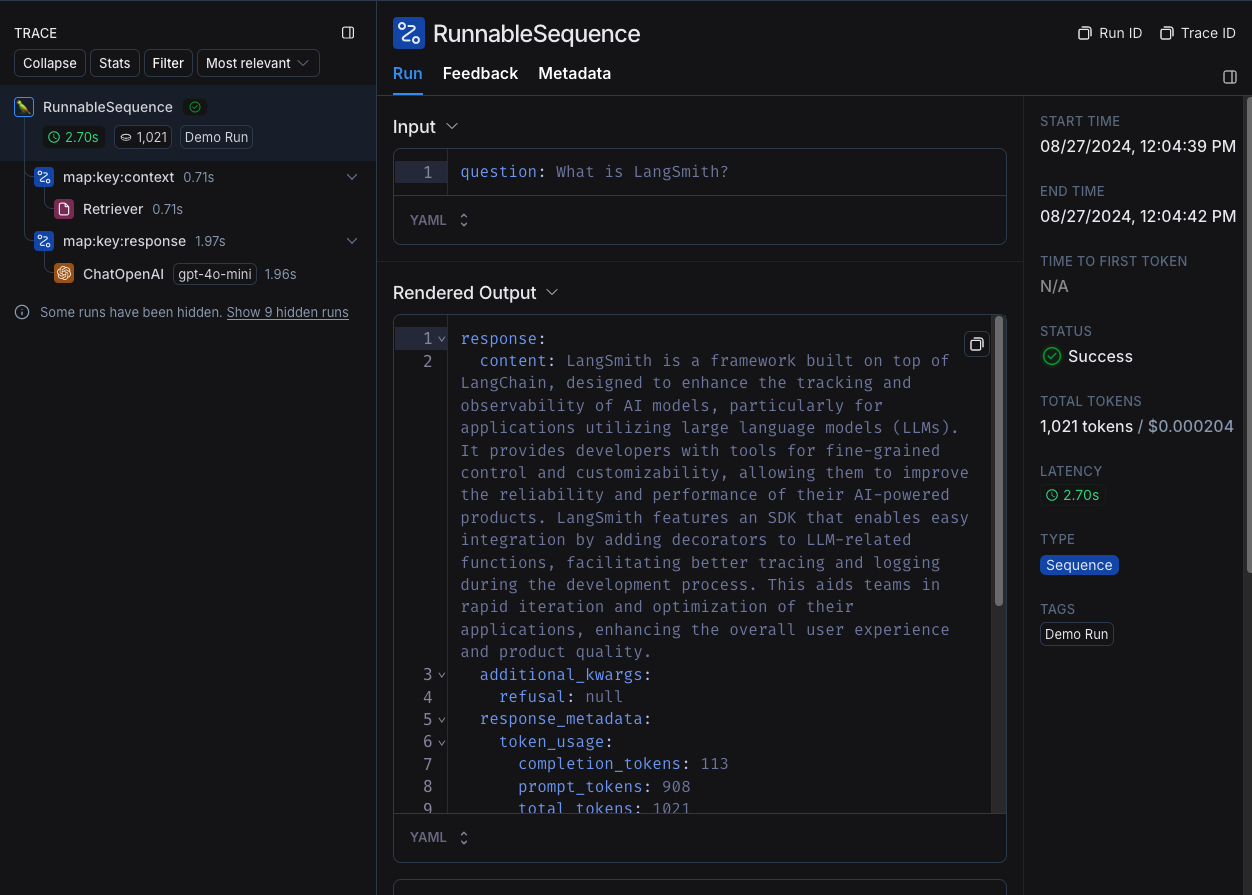

![Screenshot 2.png](<attachment:Screenshot 2.png>)
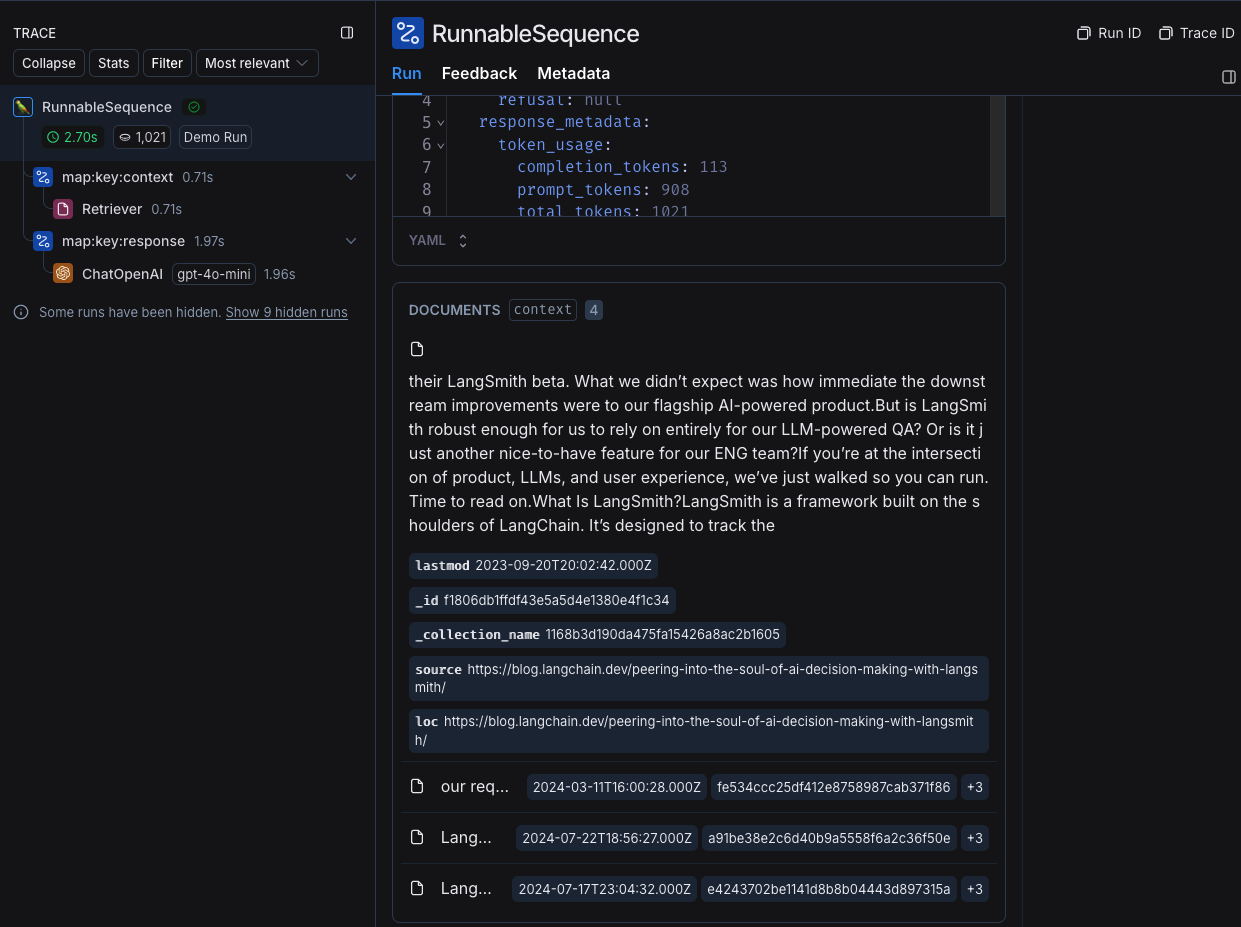

![Screenshot 3.png](<attachment:Screenshot 3.png>)
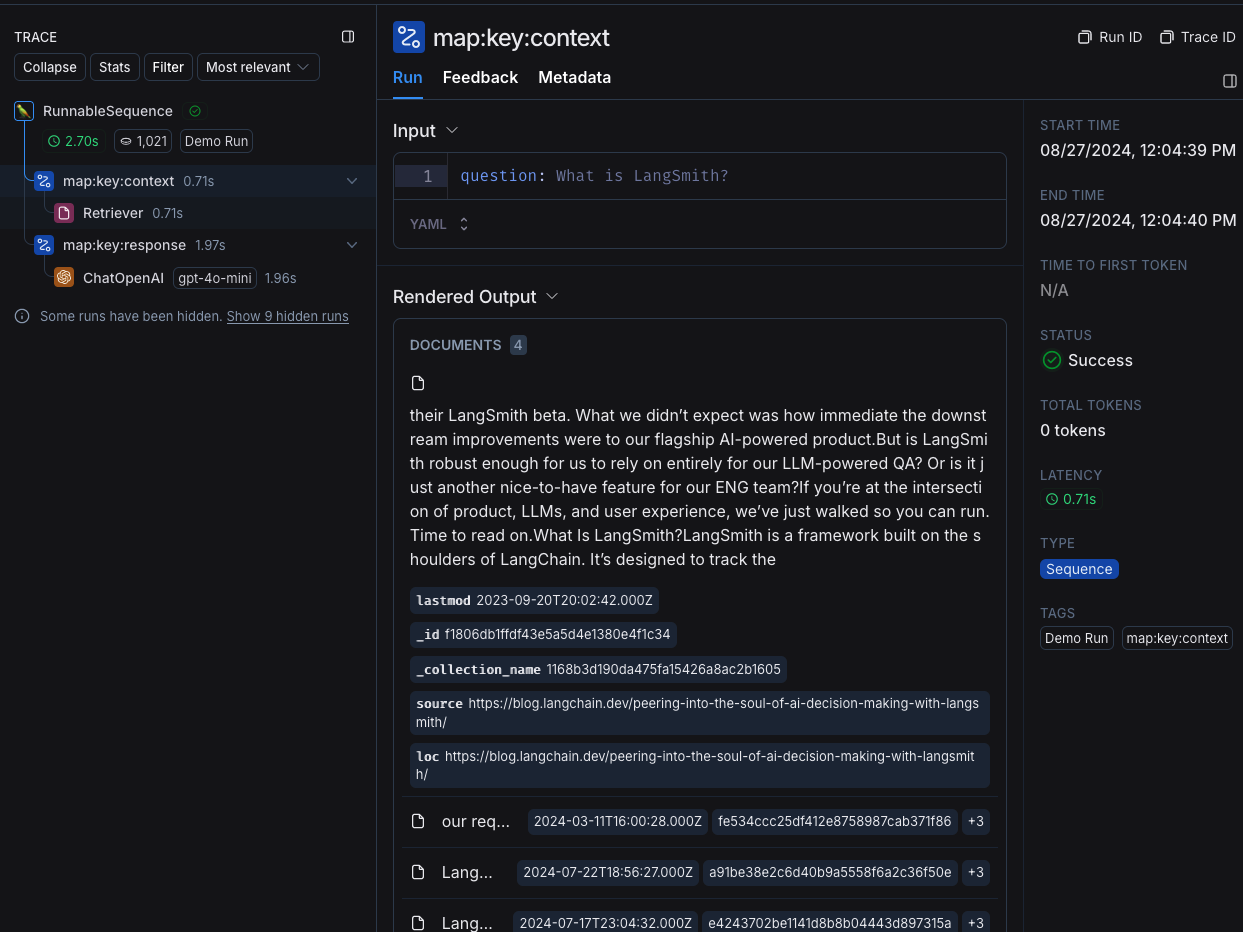

![Screenshot 4.png](<attachment:Screenshot 4.png>)
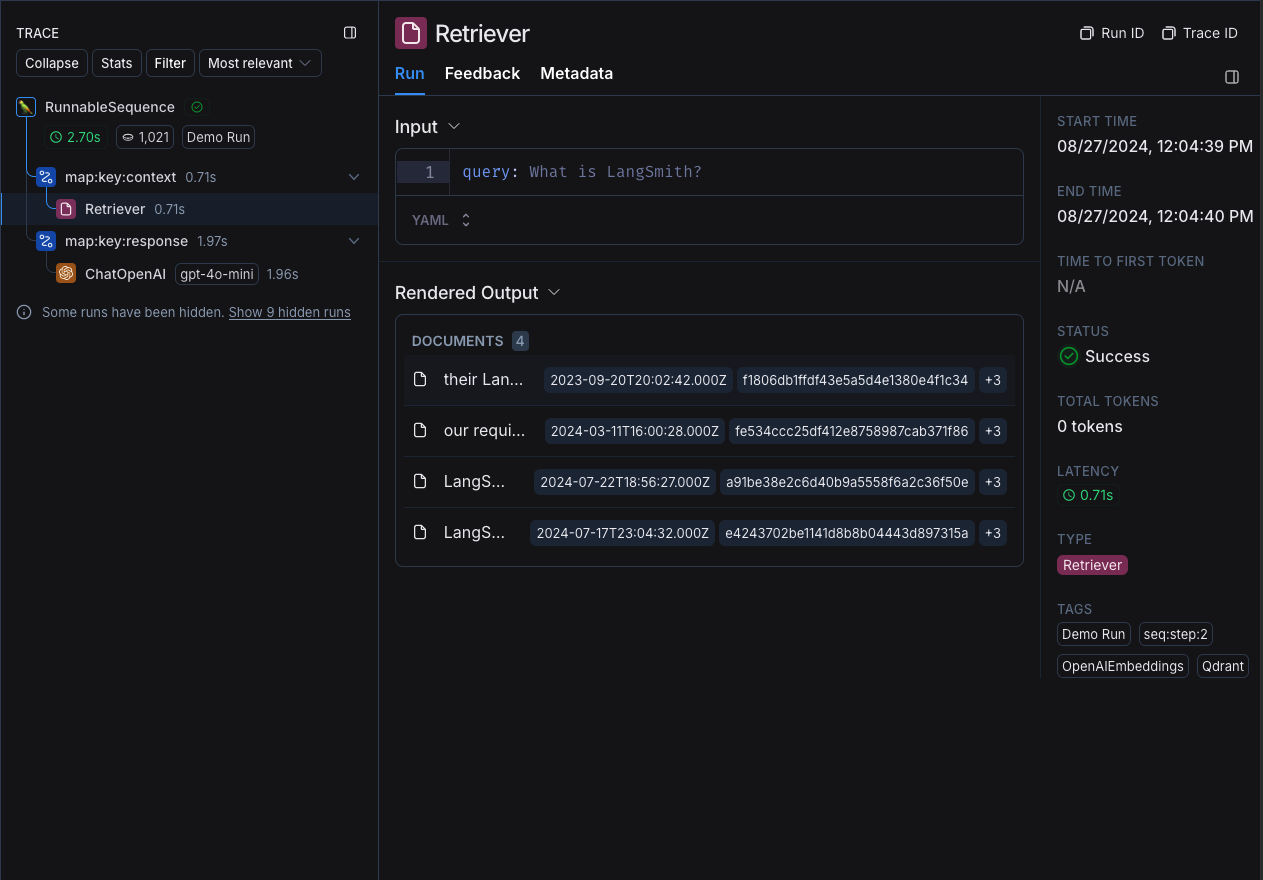

![Screenshot 5.png](<attachment:Screenshot 5.png>)
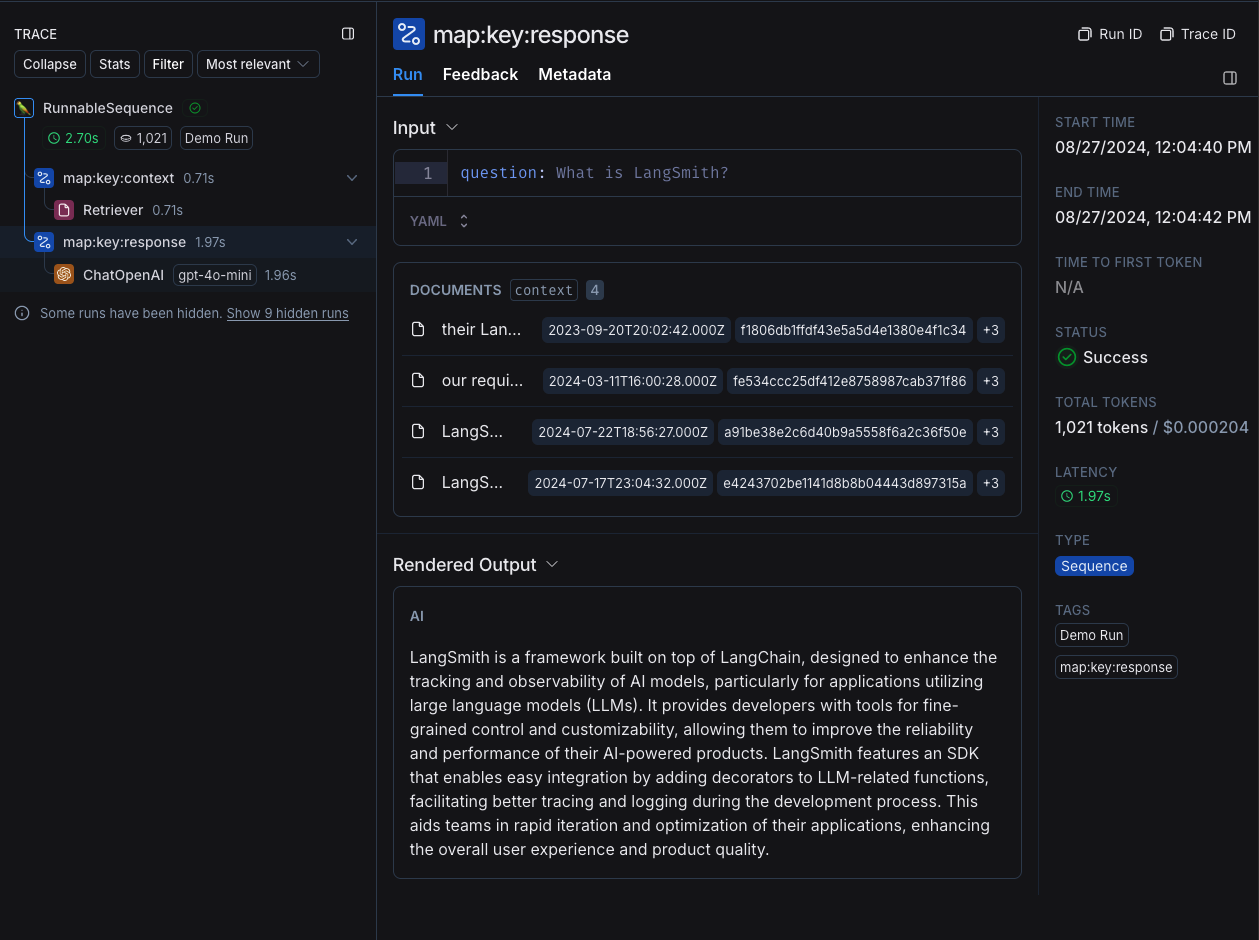

![Screenshot 6.png](<attachment:Screenshot 6.png>)
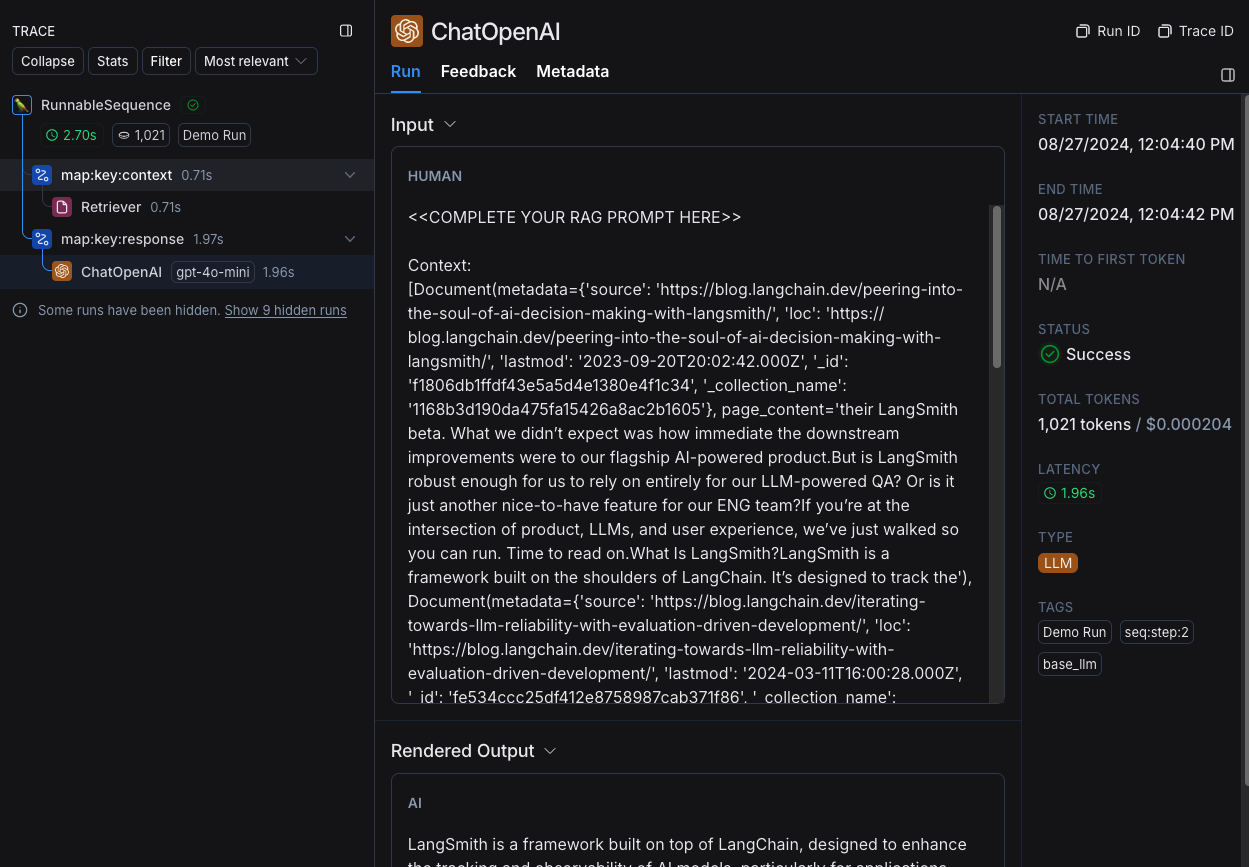

## Task 5: Loading Our Testing Set

In [32]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 84 (delta 23), reused 28 (delta 8), pack-reused 8 (from 1)
Receiving objects: 100% (84/84), 70.08 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [33]:
import pandas as pd

test_df = pd.read_csv("DataRepository/langchain_blog_test_data.csv")

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [34]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-aie4-triples-v3"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [35]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [36]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa", prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        }
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    retrieval_augmented_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

View the evaluation results for experiment: 'Base RAG Evaluation-49d1445b' at:
https://smith.langchain.com/o/0644556e-2f7e-51f7-828a-2e555502e063/datasets/a4dee2e3-bf67-496b-9c4b-c5bab54b9684/compare?selectedSessions=66bf8434-f175-481b-875b-cb543272f429




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator evaluate> on run d705f803-54fa-41c6-9710-4f7366c869d6: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-NRFljnAlwZEa3cy2MWckRBM6 on tokens per min (TPM): Limit 10000, Used 9877, Requested 456. Please try again in 1.998s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "/Users/cheselle/anaconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1267, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cheselle/anaconda3/envs/llmops-course/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/cheselle/anaconda3/envs/llmops-course/lib/python3.11/

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

#### 🟢 Answer #1:

Based on the evaluation results:
- cot contextual accuracy shows the 'correctness' of the output based on the leveraged context.
- score_string:accuracy shows the numeric level of correctness of the output on a scale of 1 to 10 with 10 being the highest
- dopeness is a subjective evaluation of the output based on how creatively appealing the answer was

The image below shows that the model made the correct logical conlcusion that Robocorp's code generation assistant is ReMark and that the answer is subjectively 'dope'

In conclusion, the evaluation model checks for proper use of context to generate a correct and creatively appealing answer 



![Screenshot 7.png](<attachment:Screenshot 7.png>)
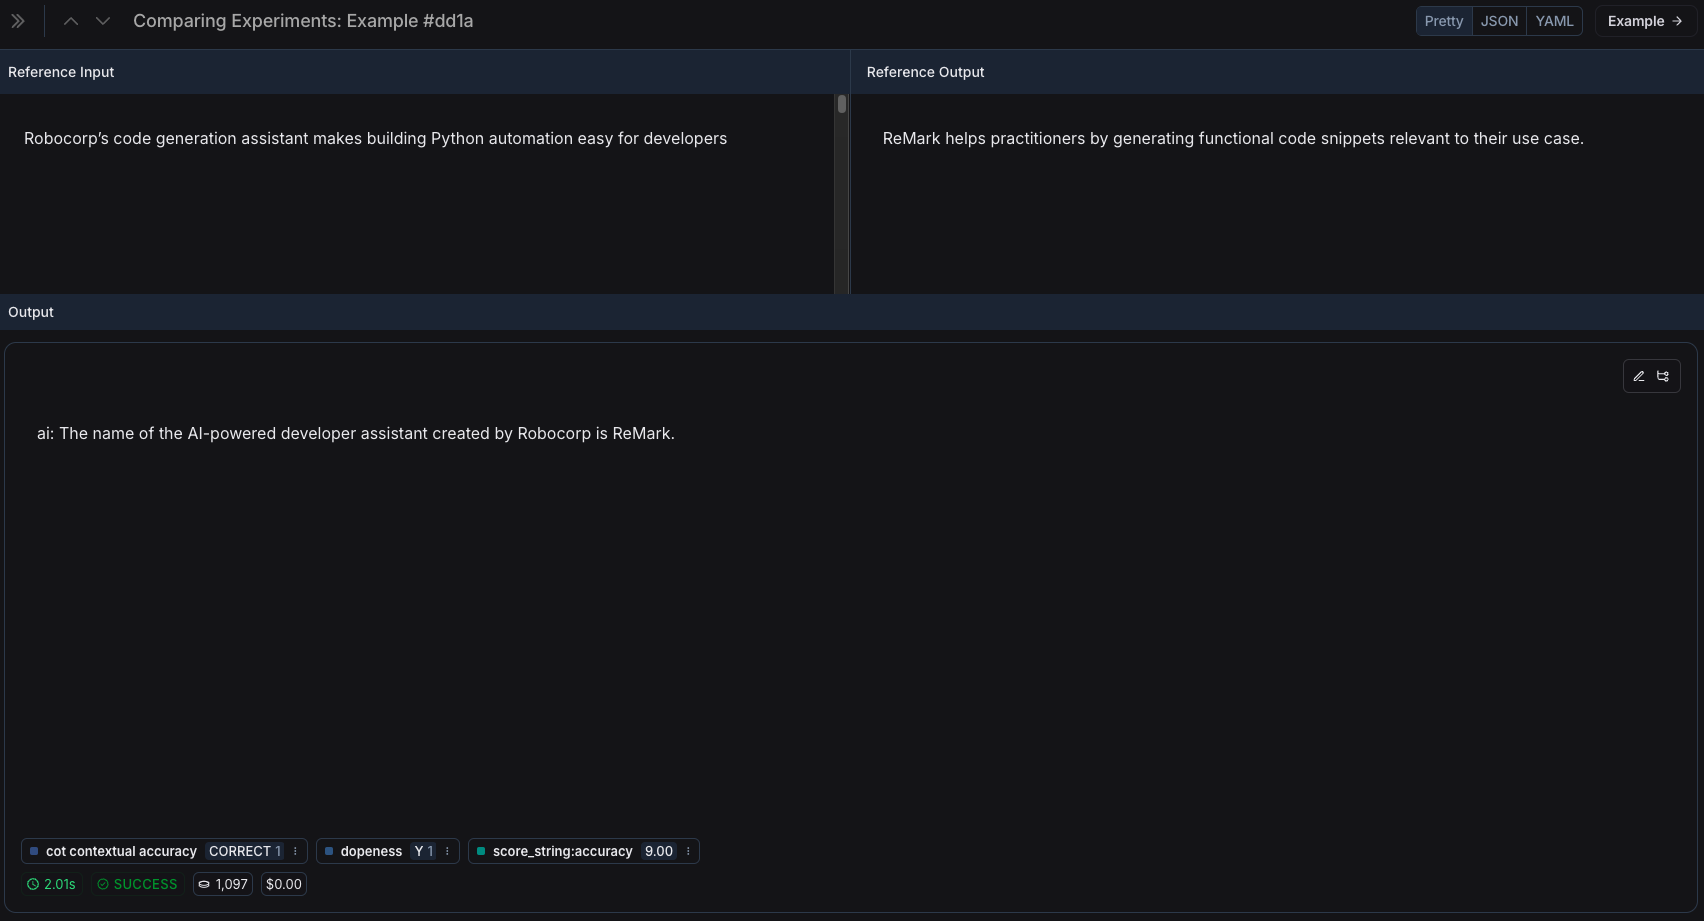